**извлечение признаков из текста на естественном языке**

кластеризатор текстов   
 SnowballStemmer + CountVectorizer + KMeans

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

SKLEARN_VERSION

'1.0.2'

In [3]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
# from nltk import download as nltk_download
# nltk_download('stopwords')

## тексты

In [4]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [5]:
data.sample(2)

,text,tag
831,"Человек-баян и техно под гитару. Как прошел отбор на ""Евровидение — 2017""\n\n30 ноября 2016 в 23:11\n\nЕвгений Карпов / Фото: Дарья Бурякина / TUT.BY\n\nНа протяжении 14 лет белорусские артисты ма...",culture
2752,\r\nВокзалы Москвы оборудовали стендами с QR-кодами для обратной связи. Любой желающий может воспользоваться брендированными табличками и оставить свой отзыв о работе вокзала.\r\n\r\nТаблички с QR...,tech


## токенизация и очистка

In [6]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()


stopwords = set(nltk_stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenize_stemmer(s): 
    p = [ stemmer.stem(w).replace('^','') for w in s.split(' ') if ( w not in stopwords ) ]
    return [ w for w in p if (len(w)>1) ]


In [7]:
# # лемматизация и очистка с помощью пакета морфологического анализа

# morph = MorphAnalyzer()

# # применяет список замен pat к строке s
# def replace_patterns(s,pat):
#     if len(pat)<1: return s
#     return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# # нормализация текста
# def string_normalizer(s):
#     pat = [
#        [r'ё','е'] # замена ё для унификации
#        ,[r'</?[a-z]+>',' '] # удаляем xml
#        ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
#        ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
#        ,[r'\w+- ',' ']
#        ,[r' +',' '] # удаляем повторы пробелов
#     ]
#     return replace_patterns(s.lower(),pat).strip()

# # NOUN (существительное), VERB (глагол), ADJF (прилагательное)
# def word_normalizer(w, pos_types=('NOUN','VERB','ADJF')):
#     if not morph.word_is_known(w): return ''
#     p = morph.parse(w)[0] 
#     return p.normal_form if (p.tag.POS in pos_types) else ''


# def tokenize_normalize(s):
#     return [ word_normalizer(w) for w in s.split(' ') if len(w)>1 ]

In [8]:
data['ctext'] = (
    data['text']
    .progress_apply(string_normalizer)
    .progress_apply(tokenize_stemmer)
    )

  0%|          | 0/3196 [00:00<?, ?it/s]

  0%|          | 0/3196 [00:00<?, ?it/s]

In [9]:
# собираем словарь из текстов
def get_vocabulary(ds):
    vcb = [ set(s) for s in ds.tolist() ]
    return sorted(set.union(*vcb))

In [10]:
vcb0 =  get_vocabulary( data['ctext'] )
print('словарь %i слов'%(len(vcb0)))
# pd.DataFrame( vcb ).to_csv('voc0.txt',index=False,header=False)

словарь 36369 слов


In [11]:
data['ctext'] = data['ctext'].apply(' '.join)

In [12]:
data.sample(10)

,text,tag,ctext
2401,"Вручение премий ""Золотой глобус"" состоится 8 января 2017 года.\n\nНоминантов на премию ""Золотой глобус"" объявила Ассоциация международной кинопрессы в понедельник, 12 декабря.\n\nПо информации Асс...",culture,вручен прем золот глобус состо январ год номинант прем золот глобус объяв ассоциац международн кинопресс понедельник декабр информац ассоциац побед сем номинац прем претенд кинокартин ла-ла-ленд с...
2050,"МОСКВА, 13 декабря. /ТАСС/. ""Лос-Анджелес Лейкерс"" потерпел поражение от ""Сакраменто"" со счетом 92:116 в гостевом матче регулярного чемпионата Национальной баскетбольной ассоциации (НБА).\n\nСамым...",sport,москв декабр тасс лос-анджелес лейкерс потерпел поражен сакрамент счет гостев матч регулярн чемпионат национальн баскетбольн ассоциац нба сам результативн игрок встреч стал форвард хозя демаркус к...
3084,Комиинформ (komiinform.ru) (Сыктывкар) Минрегионразвития РФ поддержит\n?Луд? и ?Усть-Цилемскую горку? Министр национальной политики Коми Валерий\nКоробов и первый заместитель постоянного представ...,politics,комиинформ komiinform ru сыктывкар минрегионразвит рф поддерж луд усть-цилемск горк министр национальн политик ком валер короб перв заместител постоя представител ком президент рф игор михел встре...
2312,"Сотрудница полиции, которая на своем автомобиле сбила насмерть двух пешеходов в Серпухове, уволена со службы в органах внутренних дел по отрицательным мотивам. Об этом сообщила официальный предста...",incident,сотрудниц полиц котор сво автомобил сбил насмерт двух пешеход серпухов увол служб орган внутрен дел отрицательн мотив сообщ официальн представител мвд рф ирин волк решен руководств подмосковн глав...
1486,"На парламентских выборах в Македонии победу одержала правящая партия экс-премьера Николы Груевского.\n\nНи одна из партий не сможет сформировать правительство\n\nКак сообщают СМИ, избиратели Макед...",politics,парламентск выбор македон побед одержа правя парт экс-премьер никол груевск одн парт сможет сформирова правительств сообща сми избирател македон отда парт груевск вмро-дпмн процент голос главн соп...
2972,"Дата: 11.12.2016 16:45:13\n\nАвторынок в ноябре «пошел на взлет» после 2 лет депрессии\n\nКомментируя данные по продажам автомобилей в России в ноябре этого года, председатель Комитета автопроизво...",auto,дат авторынок ноябр пошел взлет лет депресс комментиру дан продаж автомобил росс ноябр год председател комитет автопроизводител аеб йорг шрайбер отмет вперв год отрицательн тренд объединен сегмент...
216,"На следующей неделе в Волгограде откроется музей Сталина. Он будет\nнаходиться на Мамаевом кургане. Это будет частный музей. В нем будут\nпроходить выставки, посвященные роли Сталина в Великой Оте...",culture,след недел волгоград откроет муз сталин наход мамаев курган эт частн муз нем будут проход выставк посвящен рол сталин велик отечествен войн муз откр зал вип-персон
465,"Выборщик-республиканец из Техаса отказался голосовать за Трампа\n\n6 декабря 2016 в 7:06\n\nРусская служба Би-би-си\n\nЧлен коллегии выборщиков от штата Техас Крис Супрун, представляющий Республик...",politics,выборщик-республиканец техас отказа голосова трамп декабр русск служб би-би-с член коллег выборщик штат техас крис супрун представля республиканск парт заяв станет голосова дональд трамп собран эл...
946,Финиш империи. Как 25 лет назад СССР отправляли в последний путь\r\n\r\n8 декабря 2016 в 7:51\r\n\r\nTUT.BY\r\n\r\n25 лет назад председатель Верховного Совета Беларуси Станислав Шушкевич пригласил...,politics,финиш импер лет назад ссср отправля последн пут декабр tut by лет назад председател верховн совет беларус станисла шушкевич приглас сво коллег украин росс леонид кравчук борис ельцин беловежск пущ...
605,Как перестать есть слишком много сладкого: 7 практических советов\n\n9 декабря 2016 в 8:40\n\nkitchenmag.ru\n\nСахар сам по себе не представляет никакой опасности для организма. В умеренных количе...,woman,переста слишк сладк практическ совет декабр kitchenmag ru сахар представля 

##  Vectorizer

In [13]:
def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w

X = CountVectorizer(tokenizer=tokenizer, token_pattern=None).fit_transform(data['ctext'])

## кластеризируем

In [14]:
data['cluster'] = KMeans(n_clusters=12).fit(X).labels_
data['cluster'].drop_duplicates().count()

12

## тестируем

In [15]:
# номер кластера, количество объектов, метки объектов
# (cluster=-1 - некластеризованные DBSCAN объекты)
cluster_descr = pd.concat([
        data[['cluster','tag']].groupby(['cluster'])['tag'].count(),
        data[['cluster','tag']].groupby(['cluster'])['tag'].apply(lambda s: set(s)).apply(' '.join)
    ],axis=1).reset_index()

cluster_descr.columns = ['cluster','count','tags']

cluster_descr

,cluster,count,tags
0,0,24,culture politics economics auto woman sport realty social
1,1,1,woman
2,2,84,culture tech woman sport social
3,3,1,woman
4,4,1,woman
5,5,2,sport
6,6,1,social
7,7,2,woman economics
8,8,2,sport
9,9,233,reclama incident culture politics science economics auto tech woman sport realty social


<AxesSubplot:xlabel='cluster'>

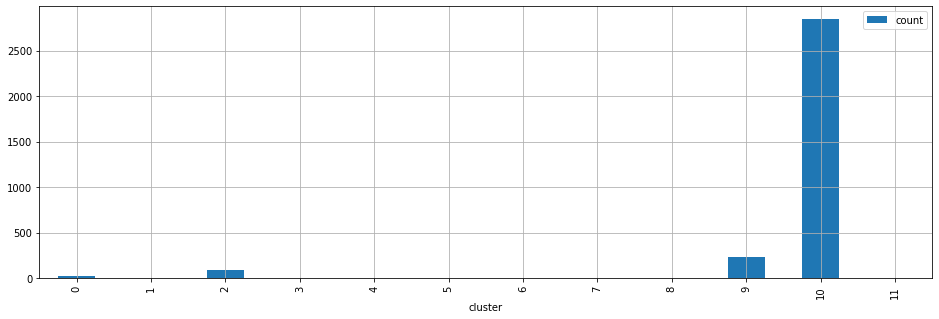

In [16]:
# размеры кластеров
cluster_descr[['cluster','count']]\
    .query('cluster>-1')\
    .set_index('cluster')\
    .plot.bar(grid=True,figsize=(16,5))

In [17]:
def print_cluster_samples(n,ns=3,nt=300):
    count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
    df = data.query(f'cluster=={n}')
    ns_ = min(ns,len(df))
    top = [ t[:nt].replace('\n',' ') for t in df['text'].sample(ns_).values ]
    print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
    for s in top: print('\n%s ...\n'%(s) )

In [18]:
for n in rng.permutation(cluster_descr['cluster'].max())[:3] :
    print_cluster_samples(n)
    print('\n= = = = = = = = = = = = = = = = = = = = = = = = = =\n')

[ КЛАСТЕР 5, элементов: 2, метки: "sport" ]

90+6' Диего Симеоне и его команда допускают очередной "ляп" в чемпионате и тем самым усложняют себе задачу. О чемпионстве "Атлетико" говорить теперь не приходится, теперь на повестке дня стоит задача по завоеванию места в еврокубковой зоне, а сделать это с такой игрой будет весьма сложно. Возможно з ...


90+6' Отличная игра - много моментов. Очень равная игра была на поле. Хозяева комбинировали и пытались владеть мячом, а гости, в основном, контратаковали.  90+6' Матч только что завершился.  90+5' Матиас Вечино (Фиорентина) разыгрывает мяч.  90+5' Хрвое Милич (Фиорентина) обострял ситуацию сейчас. О ...


= = = = = = = = = = = = = = = = = = = = = = = = = =

[ КЛАСТЕР 2, элементов: 84, метки: "culture tech woman sport social" ]

В столичном концертном зале Prime Hall прошла церемония закрытия футбольного сезона — «Звездный мяч — 2016». На ней названы лучший футболист и тренер Беларуси, лучший игрок национального чемпионата, арбитры, а также 